<a href="https://colab.research.google.com/github/jvataidee/pdi_python/blob/main/descorr_homogeneizacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Desscor e Homogeneização de contraste**




### Instalar bibliotecas

In [ ]:
!pip install spectral
!pip install rasterio

In [ ]:
# Bibliotecas
import numpy as np
from spectral import imshow
import functools
import tifffile as tiff
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
from skimage.exposure import match_histograms

In [ ]:
# Leitura da imagem
img = tif.imread(r'/content/drive/MyDrive/pdi_python/21 - PDI com Python/01 - Pré-Processamento/L71221071_07120010720_DN.tif')
img.shape

(6, 1233, 1520)

In [ ]:
def transform_to_two_dimensions(img):
    # Transformando para duas dimensões
    stack = img.reshape((-1, 6)).astype(np.float32)

    # Calculando a covariância
    cov = np.cov(stack.T)
    sigma = np.diag(np.sqrt(cov.diagonal()))
    autoval, autovec = np.linalg.eig(cov)
    stretch = np.diag(1 / np.sqrt(autoval))
    media = np.mean(stack, axis=0)
    stack -= media
    transform = functools.reduce(np.dot, [sigma, autovec, stretch, autovec.T])

    # Cálculo do deslocamento
    deslocamento = np.dot(stack, transform)

    stack = stack + media + deslocamento
    stack = stack.astype(np.uint8)  # Convertendo de volta para o tipo uint8

    # Resultado
    descorr = stack.reshape(img.shape)

    return descorr

In [ ]:
img = transform_to_two_dimensions(img)
img.shape

(6, 1233, 1520)

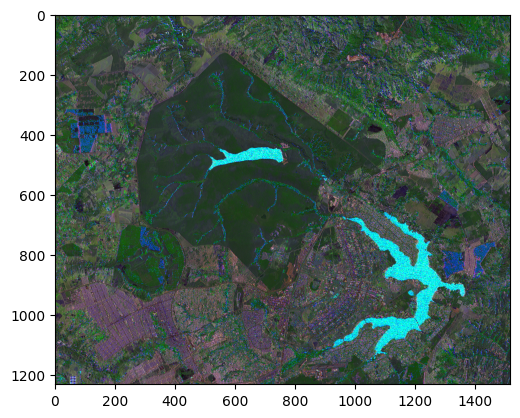

In [ ]:
band_1 = img[1, :, :]
band_2 = img[2, :, :]
band_3 = img[3, :, :]
band_4 = img[4, :, :]
band_5 = img[5, :, :]

image = np.stack((band_2, band_3, band_5), axis=-1)

# Exibindo imagem
plt.imshow(image)
plt.show()

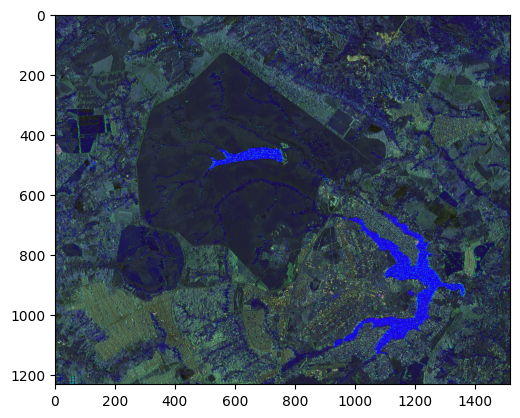

In [ ]:
band_1 = img[1, :, :]
band_2 = img[2, :, :]
band_3 = img[3, :, :]
band_4 = img[4, :, :]
band_5 = img[5, :, :]

# Criando a imagem
image = np.stack((band_1, band_2, band_3), axis=-1)

# Exibindo imagem
plt.imshow(image)
plt.show()

In [ ]:
# Definindo dados
original = img.reshape((-1,6)).astype(np.float)
nao_corr = stack

In [ ]:
nao_corr.shape

(1874160, 6)

In [ ]:
coluna = ['B1','B2','B3','B4','B5','B7']
corr = pd.DataFrame(original, columns=coluna)
n_corr = pd.DataFrame(nao_corr, columns=coluna)

In [ ]:
n_corr.tail()

,B1,B2,B3,B4,B5,B7
1874155,-102.450159,261.973021,347.679461,123.047694,330.557775,204.473109
1874156,192.406932,111.334217,243.171467,301.601897,148.960481,232.226017
1874157,249.182600,216.351712,323.206855,230.970367,429.422286,-259.039092
1874158,-31.369496,77.436096,496.943486,137.693221,238.937451,225.038473
1874159,-21.214500,903.325586,-364.099855,511.621461,-142.888710,342.315597


In [ ]:
corr.tail()

,B1,B2,B3,B4,B5,B7
1874155,247.0,36.0,55.0,42.0,55.0,46.0
1874156,35.0,32.0,48.0,55.0,42.0,45.0
1874157,50.0,53.0,61.0,57.0,47.0,231.0
1874158,250.0,21.0,66.0,45.0,44.0,44.0
1874159,39.0,101.0,12.0,45.0,14.0,45.0


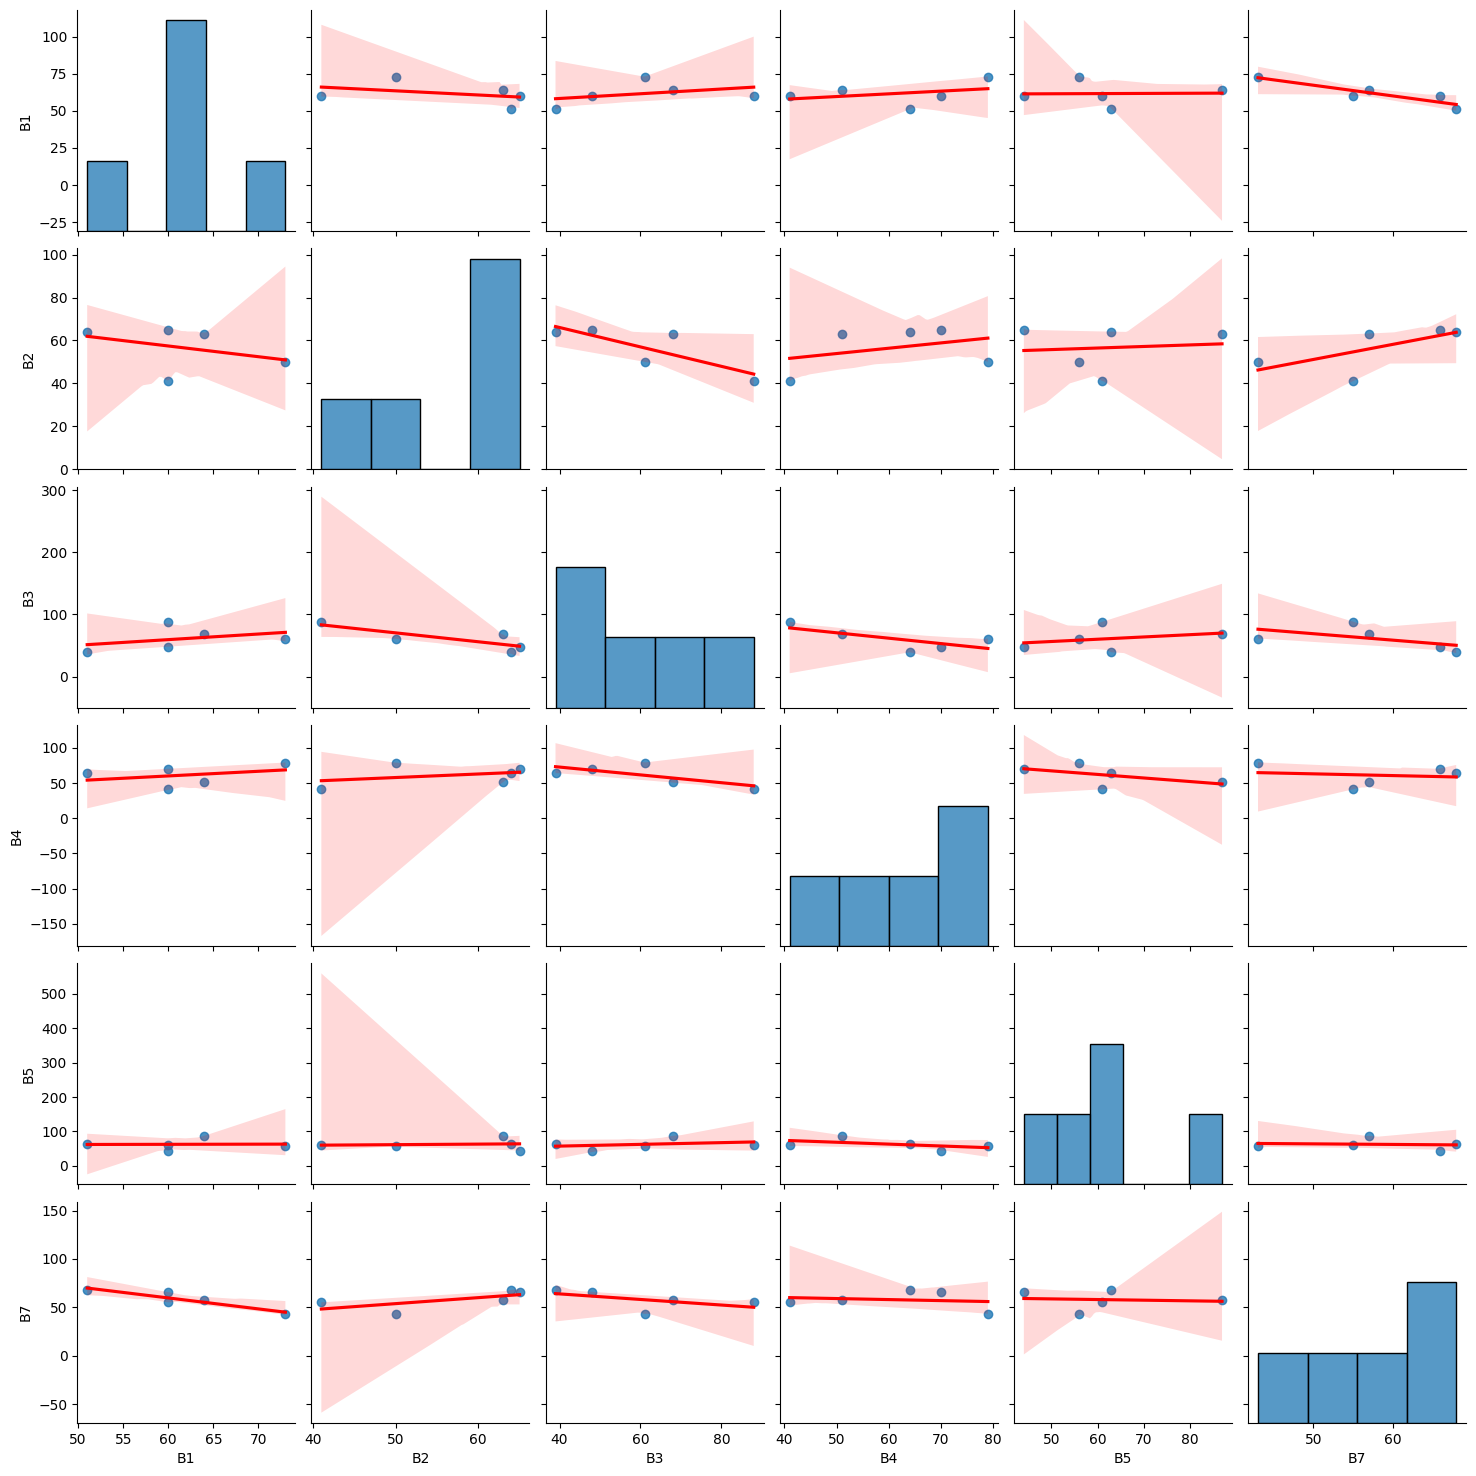

In [ ]:
sns.pairplot(corr.head(), kind='reg', plot_kws={'line_kws':{'color': 'red'}})

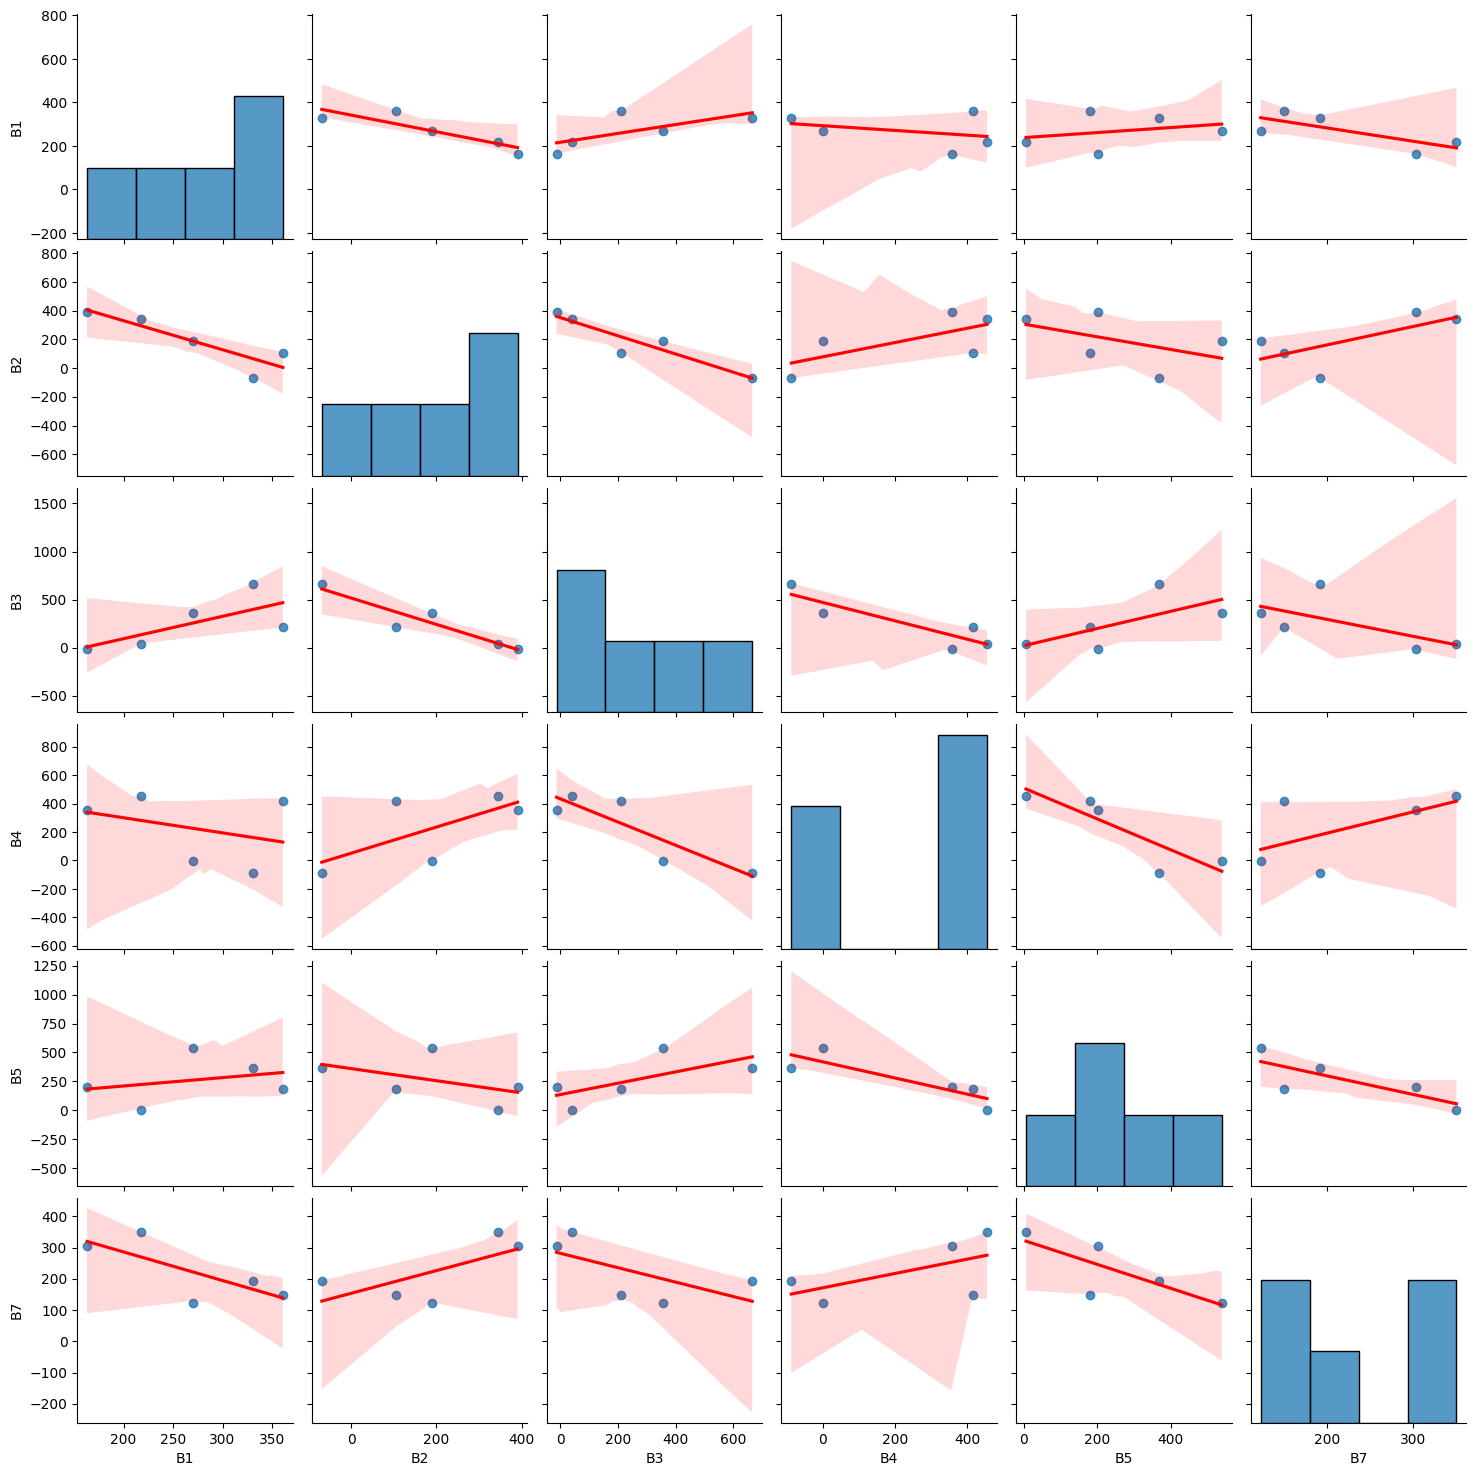

In [ ]:
sns.pairplot(n_corr.head(), kind='reg', plot_kws={'line_kws':{'color': 'red'}})

## **Homogenização**

In [ ]:
# Leitura dos arquivos
a1 = rio.open(r'/content/drive/MyDrive/pdi_python/21 - PDI com Python/02 - Transformações Espectrais e Espaciais/a1_b08.tif')
a2 = rio.open(r'/content/drive/MyDrive/pdi_python/21 - PDI com Python/02 - Transformações Espectrais e Espaciais/a2_b08.tif')

In [ ]:
# Lendo como array
imagem = a1.read(1)
referencia = a2.read(1)
meta = a1.profile

In [ ]:
meta

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 3560, 'height': 4455, 'count': 1, 'crs': CRS.from_epsg(32721), 'transform': Affine(10.0, 0.0, 573990.0,
       0.0, -10.0, 8399890.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

In [ ]:
# Aplicando método de homogeneizacao
homogeneizacao = match_histograms(imagem, referencia)

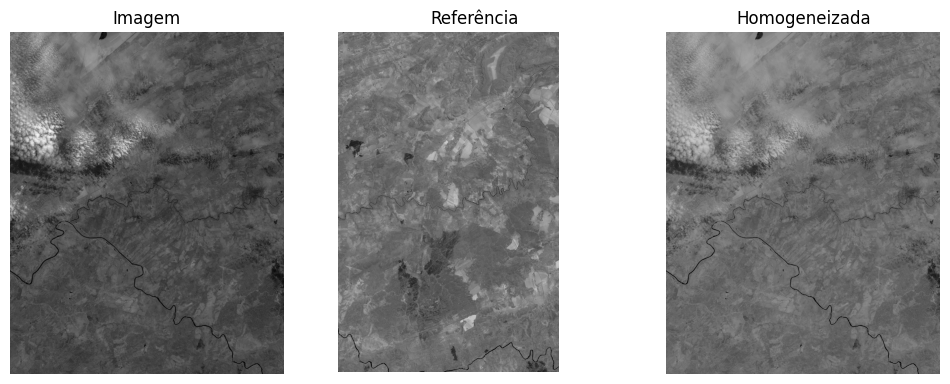

In [ ]:
# Cria uma figura e três eixos (subplots) em uma única linha
# figsize define o tamanho da figura (largura, altura) em polegadas
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(12, 8), sharex=True, sharey=True)

# Exibe a imagem original no primeiro eixo (subplot)
axis1.imshow(imagem, cmap='Greys_r')
axis1.set_title('Imagem')
axis1.set_axis_off()  # Remove os eixos do primeiro subplot

# Exibe a imagem de referência no segundo eixo (subplot)
axis2.imshow(referencia, cmap='Greys_r')
axis2.set_title('Referência')
axis2.set_axis_off()  # Remove os eixos do segundo subplot

# Exibe a imagem homogeneizada no terceiro eixo (subplot)
axis3.imshow(homogeneizacao, cmap='Greys_r')
axis3.set_title('Homogeneizada')
axis3.set_axis_off()  # Remove os eixos do terceiro subplot

# Exibe a figura com os subplots
plt.show()

/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [1468.0, 4012.0]
    G: [1468.0, 4012.0]
    B: [1468.0, 4012.0]

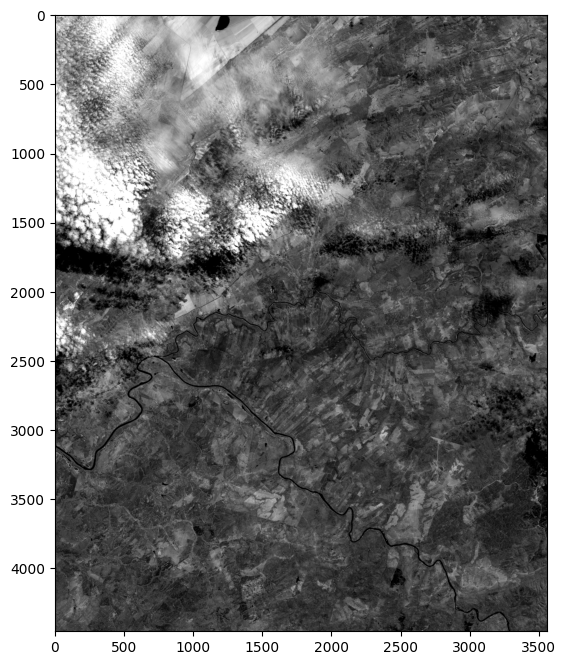

In [ ]:
imshow(imagem, stretch=(0.02,0.98), figsize=(12,8))

ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [1464.749870044484, 3018.0930251637947]
    G: [1464.749870044484, 3018.0930251637947]
    B: [1464.749870044484, 3018.0930251637947]

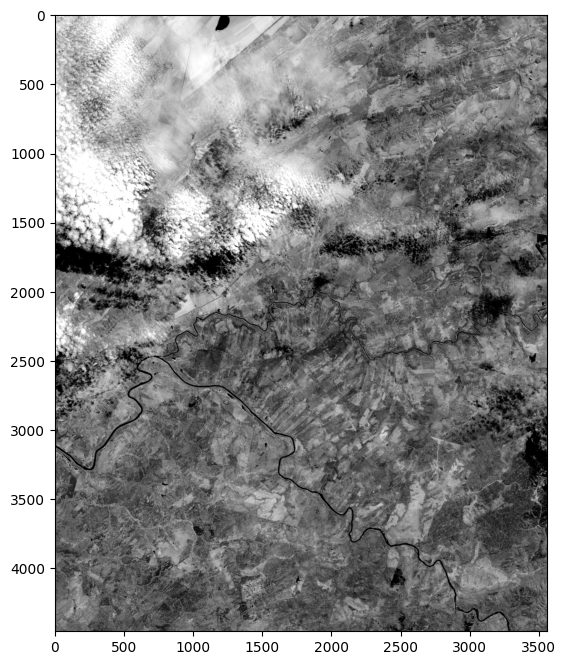

In [ ]:
imshow(homogeneizacao, stretch=(0.02,0.98), figsize=(12,8))

In [ ]:
tiff.imwrite("imagem_RGB.tif", homogeneizacao)